In [1]:
import os
import torch
import cupy as cp
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.linalg import subspace_angles
from sklearn.model_selection import KFold
from sklearn.decomposition import FactorAnalysis
from sklearn.cross_decomposition import CCA
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

In [2]:
basepath = "/home/jialab/Allensdk_data/local/ecephys_cache_dir/"
manifest_path = os.path.join(basepath, "manifest.json")
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

sessions = cache.get_session_table()
functional_connectivity_type_sessions = sessions[sessions["session_type"] == "functional_connectivity"]
functional_connectivity_type_sessions.tail()

,published_at,specimen_id,session_type,age_in_days,sex,full_genotype,unit_count,channel_count,probe_count,ecephys_structure_acronyms
id,,,,,,,,,,
835479236,2019-10-03T00:00:00Z,813701562,functional_connectivity,121.0,M,Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,582,1857,5,"[LP, DG, CA1, VISmmp, nan, SCiw, SCig, SCop, S..."
839068429,2019-10-03T00:00:00Z,817060751,functional_connectivity,129.0,F,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,742,2298,6,"[APN, LP, MB, DG, CA1, VISam, nan, VISpm, ProS..."
839557629,2019-10-03T00:00:00Z,821469666,functional_connectivity,115.0,M,Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,450,1853,5,"[APN, NOT, MB, DG, CA1, VISam, nan, VISpm, LGd..."
840012044,2019-10-03T00:00:00Z,820866121,functional_connectivity,116.0,M,Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,758,2298,6,"[APN, DG, CA1, VISam, nan, LP, VISpm, VISp, LG..."
847657808,2019-10-03T00:00:00Z,827809884,functional_connectivity,126.0,F,wt/wt,874,2298,6,"[APN, NOT, DG, HPF, ProS, CA1, VISam, nan, MB,..."


In [4]:
session = cache.get_session_data(839068429)
session.metadata

{'specimen_name': 'Sst-IRES-Cre;Ai32-434488',
 'session_type': 'functional_connectivity',
 'full_genotype': 'Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt',
 'sex': 'F',
 'age_in_days': 129.0,
 'rig_equipment_name': 'NP.2',
 'num_units': 742,
 'num_channels': 2298,
 'num_probes': 6,
 'num_stimulus_presentations': 77361,
 'session_start_time': datetime.datetime(2019, 3, 19, 12, 48, 5, tzinfo=tzoffset(None, -25200)),
 'ecephys_session_id': 839068429,
 'structure_acronyms': ['APN',
  'LP',
  'MB',
  'DG',
  'CA1',
  'VISam',
  nan,
  'VISpm',
  'ProS',
  'SUB',
  'VISp',
  'CA3',
  'VISl',
  'VIS',
  'LGd',
  'TH',
  'VISrl'],
 'stimulus_names': ['spontaneous',
  'gabors',
  'flashes',
  'drifting_gratings_contrast',
  'natural_movie_one_more_repeats',
  'natural_movie_one_shuffled',
  'drifting_gratings_75_repeats',
  'dot_motion']}

In [6]:
areas = session.structure_acronyms
print(len(areas))
print(areas)
areas = ['VISp','VISpm', 'VISam', 'LGd', 'LP']
for i, area in enumerate(areas):
    units = session.units[session.units["ecephys_structure_acronym"] == area].shape[0]
    print(f'{area}: {units}')

17
['APN', 'LP', 'MB', 'DG', 'CA1', 'VISam', nan, 'VISpm', 'ProS', 'SUB', 'VISp', 'CA3', 'VISl', 'VIS', 'LGd', 'TH', 'VISrl']
VISp: 85
VISpm: 60
VISam: 42
LGd: 9
LP: 64


In [8]:
drift_stim_table = session.get_stimulus_table('drifting_gratings_75_repeats')
drift_stim_table.head()

,contrast,orientation,phase,size,spatial_frequency,start_time,stimulus_block,stimulus_name,stop_time,temporal_frequency,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,
40339,0.8,90,"[14037.96666667, 14037.96666667]","[250.0, 250.0]",0.04,3491.787689,5,drifting_gratings_75_repeats,3493.789399,2,2.00171,2082
40340,0.8,90,"[14037.96666667, 14037.96666667]","[250.0, 250.0]",0.04,3494.790211,5,drifting_gratings_75_repeats,3496.791851,2,2.00164,2082
40341,0.1,45,"[14037.96666667, 14037.96666667]","[250.0, 250.0]",0.04,3497.792659,5,drifting_gratings_75_repeats,3499.794299,2,2.00164,2083
40342,0.1,90,"[14037.96666667, 14037.96666667]","[250.0, 250.0]",0.04,3500.795181,5,drifting_gratings_75_repeats,3502.796841,2,2.00166,2084
40343,0.1,90,"[14037.96666667, 14037.96666667]","[250.0, 250.0]",0.04,3503.797659,5,drifting_gratings_75_repeats,3505.799319,2,2.00166,2084


In [14]:
drift_stim_table['orientation'].value_counts()

45.0     150
90.0     150
135.0    150
0.0      150
Name: orientation, dtype: int64

In [75]:
def spike_matrix_blank(area, stim_table, bin=0.1, period=2, blank=0.5):
    """spike_matrix, get spike_counts using function "presentationwise_spike_counts"

    Arguments:
        area -- brain area, which need to be analyzed
        stim_table -- stimulus_table got by allensdk, which need to be analyzed

    Keyword Arguments:
        bin -- count spikes within time bin, s (default: {0.1})
        period -- the whole time period of one stimuli in drift_grating_stimuli, s (default: {2})

    Returns:
        response_matrix, shape (stims, bins, units)
    """

    area_units = session.units[session.units["ecephys_structure_acronym"] == area]  
    time_bins = np.arange(0-blank, period+bin+blank, bin)

    spike_counts = session.presentationwise_spike_counts(
        stimulus_presentation_ids=stim_table.index.values,  
        bin_edges=time_bins,
        unit_ids=area_units.index.values
    )
    
    response_matrix = spike_counts.values

    return response_matrix

def spike_counts_bins(spikes_raster, bin_len):

    if bin_len == 1:
        return
    
    trials_num, trial_len, units_num = spikes_raster.shape
    binned_trial_len = int(trial_len / bin_len)

    if (trial_len % bin_len) != 0:
        spikes_raster = np.delete(spikes_raster, range(bin_len*binned_trial_len, trial_len), 1)

    spikes_raster = spikes_raster.transpose([0, 2, 1])
    spikes_raster = spikes_raster.reshape([trials_num, units_num*binned_trial_len, bin_len])
    spikes = spikes_raster.sum(2)
    spikes = spikes.reshape([trials_num, units_num, binned_trial_len])
    spikes = spikes.transpose([0, 2, 1])

    return spikes

def spike_matrix_step(area, stim_table, bin=0.001, period=2, blank=0.5, window_len=0.1):
    """spike_matrix, get spike_counts using function "presentationwise_spike_counts"

    Arguments:
        area -- brain area, which need to be analyzed
        stim_table -- stimulus_table got by allensdk, which need to be analyzed

    Keyword Arguments:
        bin -- count spikes within time bin, s (default: {0.1})
        period -- the whole time period of one stimuli in drift_grating_stimuli, s (default: {2})

    Returns:
        response_matrix, shape (stims, bins, units)
    """

    area_units = session.units[session.units["ecephys_structure_acronym"] == area]  
    time_bins = np.arange(0-blank, period+bin+blank+window_len, bin)

    spike_counts = session.presentationwise_spike_counts(
        stimulus_presentation_ids=stim_table.index.values,  
        bin_edges=time_bins,
        unit_ids=area_units.index.values
    )
    spike_counts = spike_counts.values

    response_time = spike_counts.shape[1]-int(window_len/bin)
    response_matrix = np.zeros([spike_counts.shape[0], response_time, spike_counts.shape[2]])

    for t in np.arange(response_time):
        window = np.arange(t, t+int(window_len/bin))
        spike_counts_2 = spike_counts_bins(spike_counts[:, window, :], int(window_len/bin))
        response_matrix[:, t, :] = spike_counts_2[:, 0, :]

    return response_matrix

In [73]:
stim_table = drift_stim_table[(drift_stim_table['contrast'] == 0.8) 
                    & (drift_stim_table['orientation'] == 45.0)]
design_matrix = spike_matrix_step('VISp', stim_table)

/home/jialab/downloads/Jia_server/anaconda3/envs/env_py_36/lib/python3.6/site-packages/allensdk/brain_observatory/ecephys/ecephys_session.py:760: UserWarning: You've specified some overlapping time intervals between neighboring rows: [(3, 4), (5, 6), (6, 7), (9, 10), (14, 15), (16, 17), (24, 25), (26, 27), (38, 39), (41, 42), (44, 45), (47, 48), (72, 73)], with a maximum overlap of 0.09758252948631707 seconds.
  warnings.warn("You've specified some overlapping time intervals "


(75, 3100, 85)
3000
(75, 1, 85)
(75, 3000, 85)


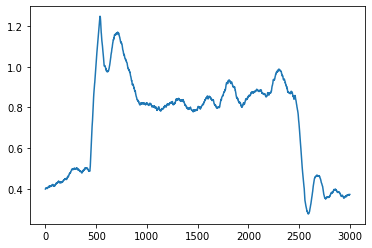

In [71]:
plt.figure()
plt.plot(design_matrix.mean(0).mean(1))

In [85]:
cont_list = [0.1, 0.8]
ori_list = [0.0, 45.0, 90.0, 135.0]

area_1 = 'VISp'
area_2 = 'VISpm'
area_3 = 'VISam'
ori_response_matrix_1 = {}
ori_response_matrix_2 = {}
ori_response_matrix_3 = {}

for i, ori in enumerate(ori_list):
    stim_table = drift_stim_table[(drift_stim_table['contrast'] == cont_list[1]) 
                        & (drift_stim_table['orientation'] == ori_list[i])]
    design_matrix_1 = spike_matrix_blank(area_1, stim_table).mean(0)
    ori_response_matrix_1[ori] = design_matrix_1
    design_matrix_2 = spike_matrix_blank(area_2, stim_table).mean(0)
    ori_response_matrix_2[ori] = design_matrix_2
    design_matrix_3 = spike_matrix_blank(area_3, stim_table).mean(0)
    ori_response_matrix_3[ori] = design_matrix_3
    
print(design_matrix_1.shape)
print(design_matrix_2.shape)
print(design_matrix_3.shape)

(30, 85)
(30, 60)
(30, 42)


(4, 30)
(4, 30)
(4, 30)


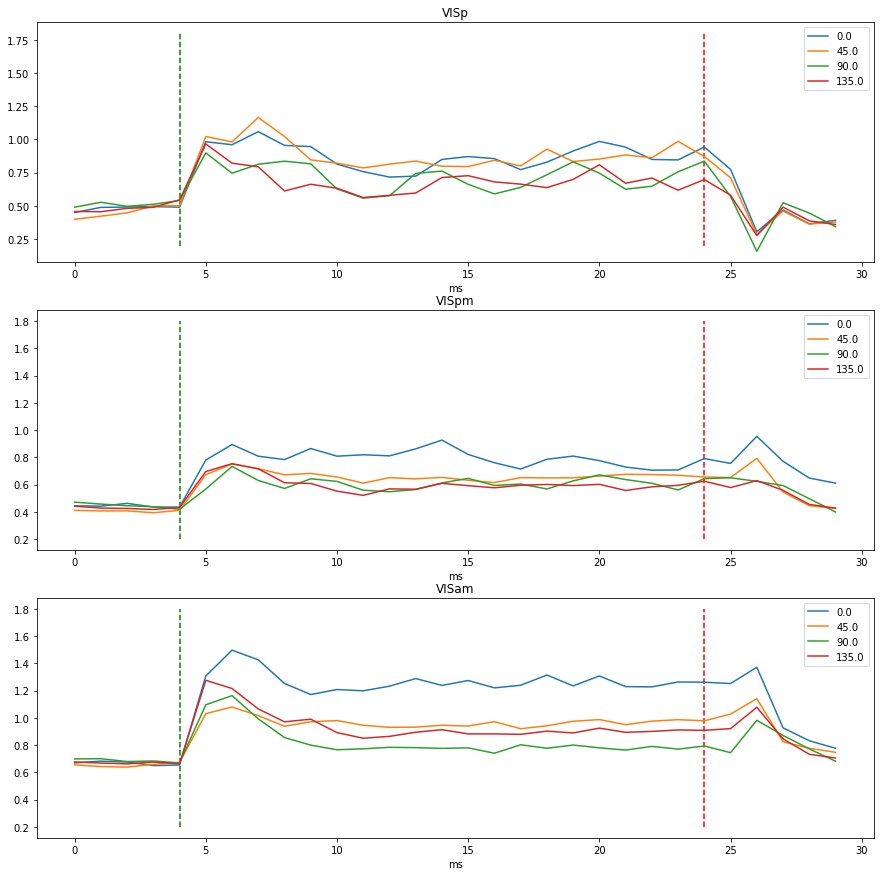

In [91]:
blank = 0.5
bin = 0.1
period = 2
time_bins = np.arange(0-blank, period+blank, bin)   

ori_response_curve_1 = np.empty([len(ori_list), len(time_bins)])
ori_response_curve_2 = np.empty([len(ori_list), len(time_bins)])
ori_response_curve_3 = np.empty([len(ori_list), len(time_bins)])

for i, ori in enumerate(ori_list):
    ori_response_curve_1[i] = ori_response_matrix_1[ori].mean(1)
    ori_response_curve_2[i] = ori_response_matrix_2[ori].mean(1)
    ori_response_curve_3[i] = ori_response_matrix_3[ori].mean(1)

print(ori_response_curve_1.shape)
print(ori_response_curve_2.shape)
print(ori_response_curve_3.shape)

f, axes = plt.subplots(nrows=3, figsize=(15, 15))

axes[0].plot(ori_response_curve_1.T)
axes[0].vlines(x=int(blank/bin-1), ymin=0.2, ymax=1.8, linestyles='dashed', color='g')
axes[0].vlines(x=int((period+blank)/bin-1), ymin=0.2, ymax=1.8, linestyles='dashed', color='r')
axes[0].legend(ori_list)
axes[0].set_title(area_1)
# axes[0].set_xticks(np.arange(len(time_bins)))
# axes[0].set_xticklabels((np.arange(len(time_bins))-blank)*100)
axes[0].set_xlabel('ms')

axes[1].plot(ori_response_curve_2.T)
axes[1].vlines(x=int(blank/bin-1), ymin=0.2, ymax=1.8, linestyles='dashed', color='g')
axes[1].vlines(x=int((period+blank)/bin-1), ymin=0.2, ymax=1.8, linestyles='dashed', color='r')
axes[1].legend(ori_list)
axes[1].set_title(area_2)
# axes[1].set_xticks(np.arange(len(time_bins)))
# axes[1].set_xticklabels((np.arange(len(time_bins))-blank)*100)
axes[1].set_xlabel('ms')

axes[2].plot(ori_response_curve_3.T)
axes[2].vlines(x=int(blank/bin-1), ymin=0.2, ymax=1.8, linestyles='dashed', color='g')
axes[2].vlines(x=int((period+blank)/bin-1), ymin=0.2, ymax=1.8, linestyles='dashed', color='r')
axes[2].legend(ori_list)
axes[2].set_title(area_3)
# axes[2].set_xticks(np.arange(len(time_bins)))
# axes[2].set_xticklabels((np.arange(len(time_bins))-blank)*100)
axes[2].set_xlabel('ms')

plt.show()

In [ ]:
cont_list = [0.1, 0.8]
ori_list = [0.0, 45.0, 90.0, 135.0]

area_1 = 'VISp'
area_2 = 'VISpm'
area_3 = 'VISam'
ori_response_matrix_1 = {}
ori_response_matrix_2 = {}
ori_response_matrix_3 = {}

for i, ori in enumerate(ori_list):
    stim_table = drift_stim_table[(drift_stim_table['contrast'] == cont_list[1]) 
                        & (drift_stim_table['orientation'] == ori_list[i])]
    design_matrix_1 = spike_matrix_blank(area_1, stim_table).mean(0)
    ori_response_matrix_1[ori] = design_matrix_1
    design_matrix_2 = spike_matrix_blank(area_2, stim_table).mean(0)
    ori_response_matrix_2[ori] = design_matrix_2
    design_matrix_3 = spike_matrix_blank(area_3, stim_table).mean(0)
    ori_response_matrix_3[ori] = design_matrix_3
    
print(design_matrix_1.shape)
print(design_matrix_2.shape)
print(design_matrix_3.shape)

In [93]:
cont_list = [0.1, 0.8]
ori_list = [0.0, 45.0, 90.0, 135.0]

area_1 = 'VISp'
area_2 = 'VISpm'
area_3 = 'VISam'
ori_response_matrix_1 = {}
ori_response_matrix_2 = {}
ori_response_matrix_3 = {}

for i, ori in enumerate(ori_list):
    stim_table = drift_stim_table[(drift_stim_table['contrast'] == cont_list[1]) 
                        & (drift_stim_table['orientation'] == ori_list[i])]
    design_matrix_1 = spike_matrix_step(area_1, stim_table).mean(0)
    ori_response_matrix_1[ori] = design_matrix_1
    design_matrix_2 = spike_matrix_step(area_2, stim_table).mean(0)
    ori_response_matrix_2[ori] = design_matrix_2
    design_matrix_3 = spike_matrix_step(area_3, stim_table).mean(0)
    ori_response_matrix_3[ori] = design_matrix_3
    
print(design_matrix_1.shape)
print(design_matrix_2.shape)
print(design_matrix_3.shape)

/home/jialab/downloads/Jia_server/anaconda3/envs/env_py_36/lib/python3.6/site-packages/allensdk/brain_observatory/ecephys/ecephys_session.py:760: UserWarning: You've specified some overlapping time intervals between neighboring rows: [(2, 3), (3, 4), (12, 13), (22, 23), (35, 36), (40, 41), (42, 43), (45, 46), (73, 74)], with a maximum overlap of 0.09754747051465529 seconds.
  warnings.warn("You've specified some overlapping time intervals "
/home/jialab/downloads/Jia_server/anaconda3/envs/env_py_36/lib/python3.6/site-packages/allensdk/brain_observatory/ecephys/ecephys_session.py:760: UserWarning: You've specified some overlapping time intervals between neighboring rows: [(3, 4), (5, 6), (6, 7), (9, 10), (14, 15), (16, 17), (24, 25), (26, 27), (38, 39), (41, 42), (44, 45), (47, 48), (72, 73)], with a maximum overlap of 0.09758252948631707 seconds.
  warnings.warn("You've specified some overlapping time intervals "
/home/jialab/downloads/Jia_server/anaconda3/envs/env_py_36/lib/python3.6/

(3000, 85)
(3000, 60)
(3000, 42)


In [94]:
blank = 0.5
bin = 0.001
period = 2
window_len = 0.1
time_bins = np.arange(0-blank, period+blank, bin)  

ori_response_curve_1 = np.empty([len(ori_list), len(time_bins)])
ori_response_curve_2 = np.empty([len(ori_list), len(time_bins)])
ori_response_curve_3 = np.empty([len(ori_list), len(time_bins)])

for i, ori in enumerate(ori_list):
    ori_response_curve_1[i] = ori_response_matrix_1[ori].mean(1)
    ori_response_curve_2[i] = ori_response_matrix_2[ori].mean(1)
    ori_response_curve_3[i] = ori_response_matrix_3[ori].mean(1)

print(ori_response_curve_1.shape)
print(ori_response_curve_2.shape)
print(ori_response_curve_3.shape)

(4, 3000)
(4, 3000)
(4, 3000)


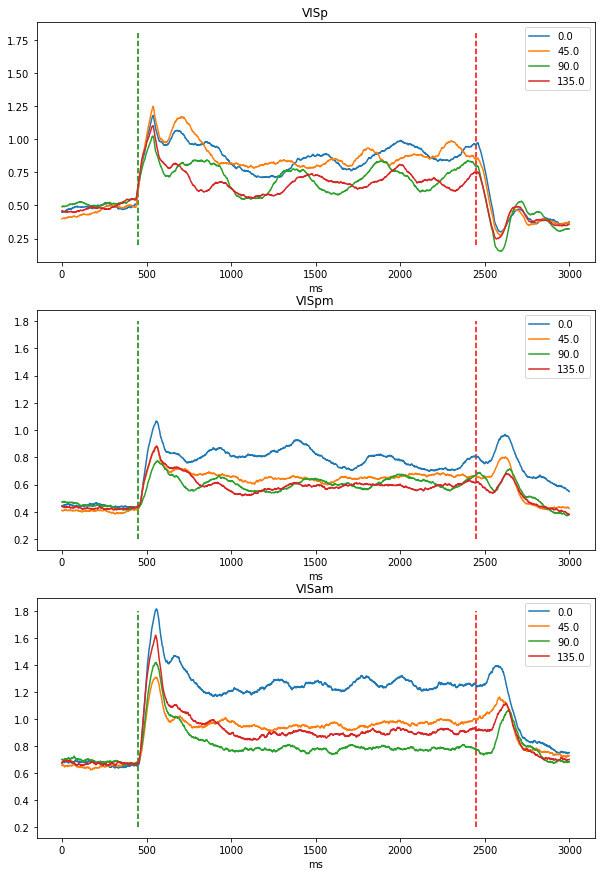

In [95]:
f, axes = plt.subplots(nrows=3, figsize=(10, 15))

axes[0].plot(ori_response_curve_1.T)
axes[0].vlines(x=(blank-window_len/2)/bin, ymin=0.2, ymax=1.8, linestyles='dashed', color='g')
axes[0].vlines(x=(period+blank-window_len/2)/bin, ymin=0.2, ymax=1.8, linestyles='dashed', color='r')
axes[0].legend(ori_list)
axes[0].set_title(area_1)
# axes[0].set_xticks(np.arange(len(time_bins)))
# axes[0].set_xticklabels((np.arange(len(time_bins))-blank)*100)
axes[0].set_xlabel('ms')

axes[1].plot(ori_response_curve_2.T)
axes[1].vlines(x=(blank-window_len/2)/bin, ymin=0.2, ymax=1.8, linestyles='dashed', color='g')
axes[1].vlines(x=(period+blank-window_len/2)/bin, ymin=0.2, ymax=1.8, linestyles='dashed', color='r')
axes[1].legend(ori_list)
axes[1].set_title(area_2)
# axes[1].set_xticks(np.arange(len(time_bins)))
# axes[1].set_xticklabels((np.arange(len(time_bins))-blank)*100)
axes[1].set_xlabel('ms')

axes[2].plot(ori_response_curve_3.T)
axes[2].vlines(x=(blank-window_len/2)/bin, ymin=0.2, ymax=1.8, linestyles='dashed', color='g')
axes[2].vlines(x=(period+blank-window_len/2)/bin, ymin=0.2, ymax=1.8, linestyles='dashed', color='r')
axes[2].legend(ori_list)
axes[2].set_title(area_3)
# axes[2].set_xticks(np.arange(len(time_bins)))
# axes[2].set_xticklabels((np.arange(len(time_bins))-blank)*100)
axes[2].set_xlabel('ms')

plt.show()